In [1]:
from pathlib import Path
import os
os.chdir("..")

In [2]:
import lovely_tensors as lt
lt.monkey_patch()

In [3]:
import pickle
from einops import rearrange
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from streamlit_drawable_canvas import st_canvas
from PIL import Image

import numpy as np
import torch

from ffss.demo.preprocess import denormalize, preprocess_support_set, preprocess_to_batch
from ffss.demo.utils import (
    COLORS,
    TEXT_COLORS,
    SupportExample,
    get_color_from_class,
    open_rgb_image,
    debug_write,
    retrieve_models,
    take_elem_from_batch,
)
from ffss.utils.utils import ResultDict, StrEnum, torch_dict_load, torch_dict_save
from ffss.models import MODEL_REGISTRY
from ffss.data import get_preprocessing
from ffss.data.utils import (
    AnnFileKeys,
    PromptType,
    BatchKeys,
    get_preprocess_shape,
)

from ffss.demo.visualize import (
    crop_seg,
    draw_all,
    draw_masks,
    feature_map_pca_heatmap,
    get_image,
    plot_seg,
)

2025-01-20 16:53:01.107 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [4]:
from ffss.demo.streamlit import load_dcama, preprocess_to_batch

In [76]:
SIZE = 384
PROMPT_SIZE = 512
CUSTOM_PREPROCESS = False
NB_FOLDER = "notebooks"

dataset_params = {
    "common": {
        "remove_small_annotations": True,
        "image_size": SIZE,
        "custom_preprocess": False
    }
}

preprocess = get_preprocessing(dataset_params)

### Get Model

In [6]:
device = "cuda"
model = load_dcama("pascal fold0 loss cross entropy soft").to(device).eval()

### Get the query image

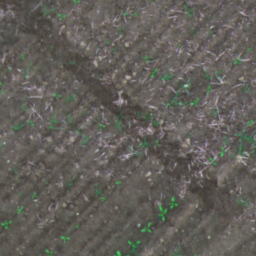

In [78]:
# query_name = NB_FOLDER + "/" + "frame0008_3.png"
query_name = NB_FOLDER + "/" + "frame0021_3.png"
query_image = Image.open(query_name)
query_image

### Get the support set

In [79]:
batch_name = open(NB_FOLDER + "/" +"crop.p", "rb")
support_batch = pickle.loads(batch_name.read())

In [80]:
batch = preprocess_to_batch(
                query_image,
                support_batch.copy(),
                preprocess,
                device=device,
            )

In [81]:
with torch.no_grad():
    result = model(batch)

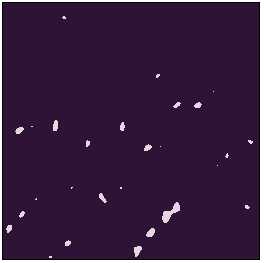

In [85]:
result[ResultDict.LOGITS].argmax(dim=1).chans

### Register the new module

In [10]:
model.register_module("reweight_conv", nn.Conv2d(3, 3, 1))

In [15]:
gt = batch[BatchKeys.PROMPT_MASKS][:, 0, 1].long()
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

In [54]:
optimizer.zero_grad()
result = model(batch)
logits = result[ResultDict.LOGITS]
loss_value = loss(logits, gt)
loss_value.backward()
optimizer.step()
print(loss_value)

tensor grad NllLoss2DBackward0 cuda:0 0.058


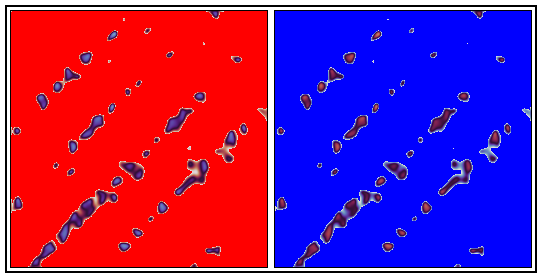

In [55]:
logits.chans

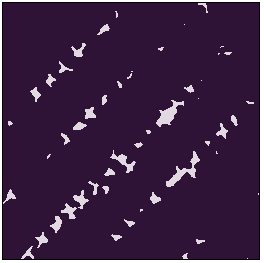

In [36]:
gt.chans

In [62]:
list(model.reweight_conv.parameters())

[Parameter[3, 3, 1, 1] n=9 x∈[-0.572, 0.485] μ=0.073 σ=0.432 grad [[[[0.441]], [[0.485]], [[-0.186]]], [[[0.474]], [[-0.572]], [[0.097]]], [[[0.011]], [[-0.552]], [[0.457]]]],
 Parameter[3] x∈[-0.297, -0.009] μ=-0.193 σ=0.160 grad [-0.273, -0.009, -0.297]]

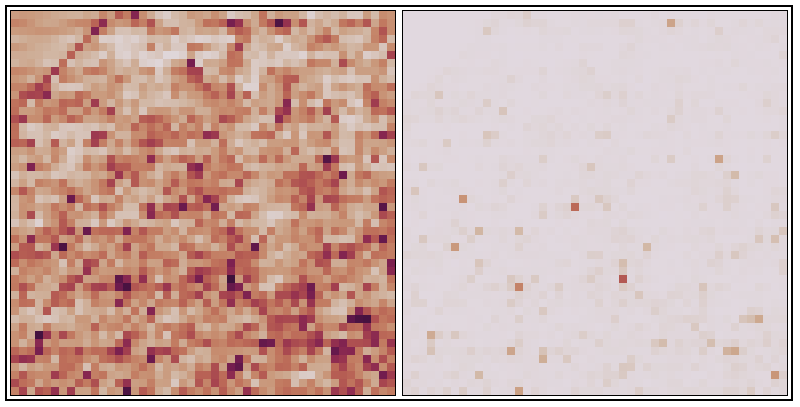

In [75]:
result[ResultDict.COARSE_MASKS_RW][0][2].chans(scale=8)